In [2]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
import json
import pickle
from networkx.generators.community import LFR_benchmark_graph
from ktools import *

importing random state


In [3]:
def save_random_state():
    random_state = np.random.get_state()
    enc = random_state[0]
    random_state_integers = random_state[1]
    random_state_params = random_state[2:]

    np.savetxt("random_state_integers.txt", random_state_integers)

    with open('random_state_params.txt', 'w') as fp:
        for item in random_state_params:
            # write each item on a new line
            fp.write("%s\n" % item)

In [3]:
#save_random_state()

# Importing Data

In [4]:
def create_adjacency(df:pd.DataFrame)->np.array:
    m = max(max(df["zero"].value_counts().index), max(df["one"].value_counts().index)) + 1
    A = np.zeros((m,m))
    a,b = df["zero"].to_numpy(dtype=int), df["one"].to_numpy(dtype=int)

    A[a,b] =1
            
    return A

In [5]:
def import_random_state():
    random_state_integers = np.loadtxt("random_state_integers.txt")
    enc="MT19937"
    params = []
    with open(r'random_state_params.txt', 'r') as fp:
        for line in fp:
            # remove linebreak from a current name
            # linebreak is the last character of each line
            x = line[:-1]

            # add current item to the list
            params.append(x)

    params[0] = int(params[0])
    params[1] = int(params[1])
    params[2] = float(params[2])

    params.insert(0,enc)
    params.insert(1, random_state_integers)
    
    return tuple(params)

In [6]:
np.random.set_state(import_random_state())

In [8]:
data = pd.read_csv(r"data\email-Eu-core-temporal.txt.gz")
data = data.map(str.split)
series_d, series_0,  series_1, t = data.map(lambda x:(x[0], x[1])).values.flatten(),data.map(lambda x:x[0]).values.flatten(), data.map(lambda x:x[1]).values.flatten(), data.map(lambda x:x[2]).values.flatten()

series_d = pd.Series(series_d)
wt = pd.Series(series_d).value_counts()


to_integer = np.vectorize(int)
edges = pd.DataFrame({"zero": to_integer(series_0), "one": to_integer(series_1), "d": series_d, "w": series_d.map(lambda x: wt[x])})


edges

,zero,one,d,w
0,168,472,"(168, 472)",668
1,168,912,"(168, 912)",1212
2,2,790,"(2, 790)",229
3,2,322,"(2, 322)",10
4,2,790,"(2, 790)",229
...,...,...,...,...
332328,324,367,"(324, 367)",1
332329,790,126,"(790, 126)",150
332330,790,126,"(790, 126)",150
332331,782,126,"(782, 126)",54


In [25]:
#handling the edges
data = pd.read_csv(r"data\email-Eu-core.txt.gz")
data = data.map(str.split)
series_0 = data.map(lambda x:x[0]).values.flatten()
series_1 = data.map(lambda x:x[1]).values.flatten()

to_integer = np.vectorize(int)
series_0 = to_integer(series_0)


df = pd.DataFrame({"zero": to_integer(series_0), "one": to_integer(series_1)})
df = df.dropna()
df

,zero,one
0,2,3
1,2,4
2,5,6
3,5,7
4,8,9
...,...,...
25565,420,143
25566,174,859
25567,440,460
25568,52,786


In [26]:
# Handling the Labels
labels = pd.read_csv(r"data\email-Eu-core-department-labels.txt.gz")

labels= labels.map(str.split)
series_0 = labels.map(lambda x:x[0]).values.flatten()
series_1 = labels.map(lambda x:x[1]).values.flatten()

to_integer = np.vectorize(int)
series_0 = to_integer(series_0)
labels = pd.DataFrame({"node": to_integer(series_0), "label": to_integer(series_1)})
labels = labels.dropna()

In [27]:
comms = {label: list(labels[labels["label"] == label]["node"]) for label in labels["label"].unique()}
labels["community"] = labels["label"].map(comms)

In [28]:
A = create_adjacency(df)
eucore = nx.from_numpy_array(A)
nx.set_node_attributes(eucore, labels["community"], "community")
nx.set_node_attributes(eucore, labels["label"], "label")
eucore.remove_node(1004)


In [29]:
mu = nx.attribute_assortativity_coefficient(eucore, "label")

print(f"mixing parameter eucore: {mu}")

mixing parameter eucore: 0.06838781421256855


# Importing Data

## Generating Synthetic Networks

In [30]:
def net_comm_stats(G: nx.Graph, title:str, node_size=300, show_graph=False)->dict:
    """Creates a dictionary of summary statistics for a list of communties

    Args:
        G nx.Graph: Graph that originated the communities
        title str: Title of the graph
    Returns:
        dict: summary statistics
    """    
    comms = {frozenset(G.nodes[v]["community"]) for v in G}
    comms = [list(x) for x in comms]

    # ------------------------- create summary statistics ------------------------ #
    stats = {}
    stats["n_of_nodes"] = len(G.nodes)
    stats["n_edges"] = len(G.edges)

    stats["a_comm_size"] = np.mean([len(c) for c in comms])
    stats["var_comm_size"] = np.var([len(c) for c in comms])

    stats["a_deg"] = np.mean([x for x in dict(nx.degree(G)).values()])
    stats["min_deg"] = np.min([x for x in dict(nx.degree(G)).values()])
    stats["max_deg"] = np.max([x for x in dict(nx.degree(G)).values()])
    
    stats["a_btw_centrality"] = np.mean([x for x in nx.betweenness_centrality(G).values()])

    if show_graph:
        color_dict = {}

        a = [frozenset(G.nodes[v]['community']) for v in G]    

        for node in a:
            if node not in color_dict:
                color_dict[node] = 0

        for i,key in enumerate(color_dict.keys()):
            color_dict[key] = plt.colormaps["tab20"](i)

        pos = nx.kamada_kawai_layout(G)
        node_colors = [color_dict[frozenset(G.nodes[node]['community'])] for node in G.nodes]
        nx.draw(G, node_color=node_colors, node_size=node_size, font_size=16,  arrows=True, pos=pos, with_labels=True)
        plt.title(f"Graph of the {title} network, with underlying communities", fontsize=16)

    return stats


In [31]:
def gen_net(n:int, tau1:float, tau2:float, mu:float, name, kw ={}):
    """Generates network with params, saves file to pickle

    Args:
        n (int): size of net
        tau1 (float): exponent param dist
        tau2 (float): exponent param dist 2
        mu (float): mixing param
        name (_type_): name of the save file
        kw (dict, optional): kw args. Defaults to {}.

    Returns:
        None
    """
    n = n
    tau1 = tau1
    tau2 = tau2
    mu = mu
    cond = False
    counter = 1
    
    while not cond:
        try:
            print(f"{counter}")
            G = LFR_benchmark_graph(
                n, tau1, tau2, mu, **kw)
            cond = True
            
        except:
            counter +=1

    a = [G.nodes[v]["community"] for v in G]
    I = flow_id_from_graph(G)
    G = nx.from_numpy_array(I)
    nx.set_node_attributes(G, dict(enumerate(a)), "community")
    pickle.dump(G, open(f'{name}.pickle', 'wb'))



In [38]:
n = 2500
tau1 = 2.5
tau2 = 1.5
mu = 0.225
kw = {"min_community":10,
      "average_degree":30,
      "max_iters":1000}
name = "large250"

cond = False
counter = 1

while not cond:
      try:
            print(f"{counter}")
            G = LFR_benchmark_graph(
                  n, tau1, tau2, mu, **kw)
            cond = True
      except:
            counter +=1

pickle.dump(G, open(f'{name}.pickle', 'wb'))

1
2
3


In [19]:
name = 'large250.pickle'
I =np.loadtxt("large.txt")
G = pickle.load(open('large250.pickle', 'rb'))

In [20]:
a = [G.nodes[v]["community"] for v in G]
G = nx.from_numpy_array(I)
nx.set_node_attributes(G, dict(enumerate(a)), "community")
pickle.dump(G, open(f'{name}', 'wb'))

In [21]:
len(G.edges)

17321

### Small50

In [83]:

n = 50
tau1 = 3
tau2 = 1.5
mu = 0.225
kw = {"min_community":6,
      "average_degree":4,
      "max_iters":1000}
name = "small50"

G = gen_net(n, tau1, tau2, mu, name, kw)

1


100%|██████████| 50/50 [00:00<00:00, 55.36it/s]


{'n_of_nodes': 50,
 'n_edges': 160,
 'a_comm_size': 7.142857142857143,
 'var_comm_size': 0.9795918367346939,
 'a_deg': 6.4,
 'min_deg': 0,
 'max_deg': 15,
 'a_btw_centrality': 0.03562925170068028}

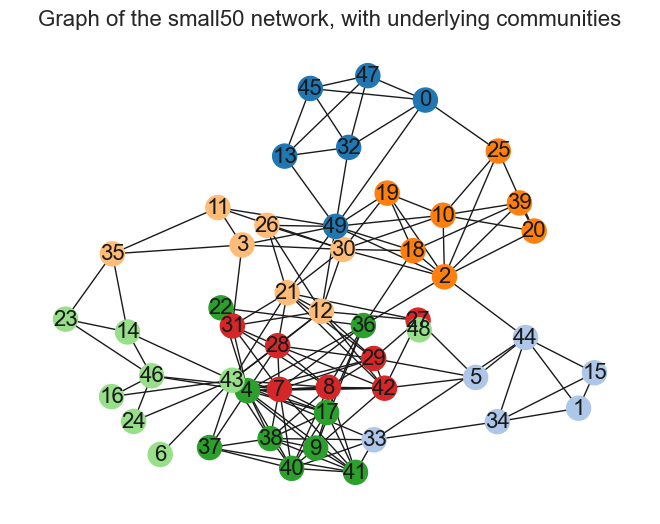

In [84]:
G = pickle.load(open('small50.pickle', 'rb'))
net_comm_stats(G, "small50", show_graph=True)

## Medium 250

In [85]:
n = 250
tau1 = 2.5
tau2 = 1.5
mu = 0.225
kw = {"min_community":10,
      "average_degree":6,
      "max_iters":1000}
name = "medium250"

G = gen_net(n, tau1, tau2, mu, name, kw)

1


  0%|          | 0/250 [00:00<?, ?it/s]

100%|██████████| 250/250 [02:51<00:00,  1.46it/s]


In [86]:
G = pickle.load(open('medium250.pickle', 'rb'))
net_comm_stats(G, "medium250", 50)

{'n_of_nodes': 250,
 'n_edges': 3937,
 'a_comm_size': 17.857142857142858,
 'var_comm_size': 34.55102040816327,
 'a_deg': 31.496,
 'min_deg': 0,
 'max_deg': 117,
 'a_btw_centrality': 0.004991061018266615}

## Large 2500

In [10]:
from networkx.generators.community import LFR_benchmark_graph
n = 1000
tau1 = 2.5
tau2 = 1.5
mu = 0.225
G = LFR_benchmark_graph(
    n, tau1, tau2, mu, average_degree=30, min_community=20
)
x = nx.to_numpy_array(G)
np.savetxt("large_no_flow.txt",x)


In [8]:
I = np.loadtxt("large_no_flow.txt")

In [13]:
a = [G.nodes[v]["community"] for v in G]

G = nx.from_numpy_array(I)

nx.set_node_attributes(G, dict(enumerate(a)), "community")
pickle.dump(G, open('large250.pickle', 'wb'))


## Generating Transfer Learning Training Sets

In [89]:
n = 250
tau1 = 2.5
tau2 = 1.5
mu = 0.06

kw = {"average_degree":33/4,
      "min_community":10,
      "max_iters":1000}
name = "transfer250"
G = gen_net(n, tau1, tau2, mu, name, kw)

1
2
3
4


100%|██████████| 250/250 [05:18<00:00,  1.27s/it]


## Generating mu sets

In [15]:
n = 250
tau1 = 2.5
tau2 = 1.5
kw = {"min_community":10,
      "average_degree":6,
      "max_iters":1000}

for mu in np.arange(0.1,0.9, 0.1):
    name = f"medium250_{mu}"
    G = gen_net(n, tau1, tau2, mu, name, kw)

1
2
3
4
5
6
7


100%|██████████| 250/250 [03:02<00:00,  1.37it/s]


1
2


100%|██████████| 250/250 [03:39<00:00,  1.14it/s]


1
2


100%|██████████| 250/250 [03:14<00:00,  1.29it/s]


1


100%|██████████| 250/250 [08:29<00:00,  2.04s/it] 


1
2


100%|██████████| 250/250 [33:40<00:00,  8.08s/it]   


1


100%|██████████| 250/250 [04:02<00:00,  1.03it/s]


1


100%|██████████| 250/250 [04:14<00:00,  1.02s/it]


1


100%|██████████| 250/250 [04:29<00:00,  1.08s/it]


In [69]:
G_small = pickle.load(open('small50.pickle', 'rb'))

G_small.nodes[0]["community"]
communities = {frozenset(G_small.nodes[node]["community"]) for node in G_small.nodes}

np.average([len(com) for com in communities])
np.var([len(com) for com in communities])


np.max([y for x,y in G_small.degree])

15

In [43]:
G_medium = pickle.load(open('medium250.pickle', 'rb'))

In [68]:
communities = {frozenset(G_medium.nodes[node]["community"]) for node in G_medium.nodes}

np.average([len(com) for com in communities])
np.var([len(com) for com in communities])   
np.max([y for x,y in G_medium.degree])

117

In [46]:
G_large = pickle.load(open('large250.pickle', 'rb'))


In [67]:
communities = {frozenset(G_large.nodes[node]["community"]) for node in G_large.nodes}

np.average([len(com) for com in communities])
np.var([len(com) for com in communities])
np.max([y for x,y in G_large.degree])

472